In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [2]:
data = pd.read_parquet(Path('data') / 'train.parquet')

In [3]:
import seaborn as sns
sns.set_style('darkgrid')

In [4]:
data['log_bike_count'] = np.log(1 + data['bike_count'])

In [5]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, 'year'] = X['date'].dt.year
    X.loc[:, 'month'] = X['date'].dt.month
    X.loc[:, 'day'] = X['date'].dt.day
    X.loc[:, 'weekday'] = X['date'].dt.weekday
    X.loc[:, 'hour'] = X['date'].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"]) 

In [6]:
from sklearn.preprocessing import FunctionTransformer

date_encoder = FunctionTransformer(_encode_dates, validate=False)
date_encoder.fit_transform(data[['date']]).head()

,year,month,day,weekday,hour
48321,2020,9,1,1,2
48324,2020,9,1,1,3
48327,2020,9,1,1,4
48330,2020,9,1,1,15
48333,2020,9,1,1,18


In [7]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)

enc.fit_transform(_encode_dates(data[['date']])[['hour']].head())

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [8]:
import problem

X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[['date']]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer([
    ('date', OneHotEncoder(handle_unknown="ignore"), date_cols),
    ('cat', categorical_encoder, categorical_cols),
])

regressor = Ridge()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x000001F9009AAA60>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('ridge', Ridge())])

In [10]:
from sklearn.metrics import mean_squared_error

print(f'Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}')
print(f'Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):.2f}')

Train set, RMSE=0.80
Test set, RMSE=0.73


In [11]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error')
print('RMSE: ', scores)
print(f'RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}')

RMSE:  [-0.82871796 -1.01361312 -0.82011608 -1.08268223 -0.94019597 -1.42230367]
RMSE (all folds): 1.02 ± 0.204


In [12]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[['date']]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer([
    ('date', "passthrough", date_cols),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
])

regressor = HistGradientBoostingRegressor(random_state=0)

pipe =  make_pipeline(date_encoder, preprocessor, regressor)
pipe

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x000001F9009AAA60>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date', 'passthrough',
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(random_state=0))])

In [13]:
scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error', error_score=np.nan)
print(f'RMSE: {-scores.mean():.3} ± {(-scores).std():.3}')

RMSE: 1.19 ± 0.242


In [14]:
# In this notebook we define the __file__ variable to be in the same conditions as when running the
# RAMP submission

__file__ = Path('submissions') /  'starting_kit' /  'estimator.py'


def _merge_external_data(X):
    file_path = Path(__file__).parent / 'external_data.csv'
    df_ext = pd.read_csv(file_path, parse_dates=['date'])
    
    X = X.copy()
    # When using merge_asof left frame need to be sorted
    X['orig_index'] = np.arange(X.shape[0])
    X = pd.merge_asof(X.sort_values('date'), df_ext[['date', 't','raf10','ff','rr1']].sort_values('date'), on='date')
    # Sort back to the original order
    X = X.sort_values('orig_index')
    del X['orig_index']
    return X
    

In [15]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[['date']]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

numeric_cols = ['t','raf10','ff','rr1']

preprocessor = ColumnTransformer([
    ('date', "passthrough", date_cols),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
    ('numeric', 'passthrough', numeric_cols)
])

regressor = HistGradientBoostingRegressor(random_state=0)

pipe =  make_pipeline(
    FunctionTransformer(_merge_external_data, validate=False),
    date_encoder,
    preprocessor,
    regressor
)

In [16]:
import time

In [17]:
start = time.time()
scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error', error_score=np.nan,verbose=2,n_jobs=-1)
end = time.time()
timed= end - start
print("%1.2e seconds"%timed)
print(f'RMSE: {-scores.mean():.3} ± {(-scores).std():.3}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   22.8s remaining:   22.8s


3.22e+01 seconds
RMSE: 1.18 ± 0.239


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   31.9s finished


In [18]:
merger = pipe[:2]
X_train_augmented = merger.transform(X_train)
X_test_augmented = merger.transform(X_test)

predictor = pipe[2:]
_ = predictor.fit(X_train_augmented, y_train)

In [19]:
from sklearn.inspection import permutation_importance

feature_importances = permutation_importance(
    predictor, X_train_augmented[:20000], y_train[:20000], n_repeats=10, random_state=0
)

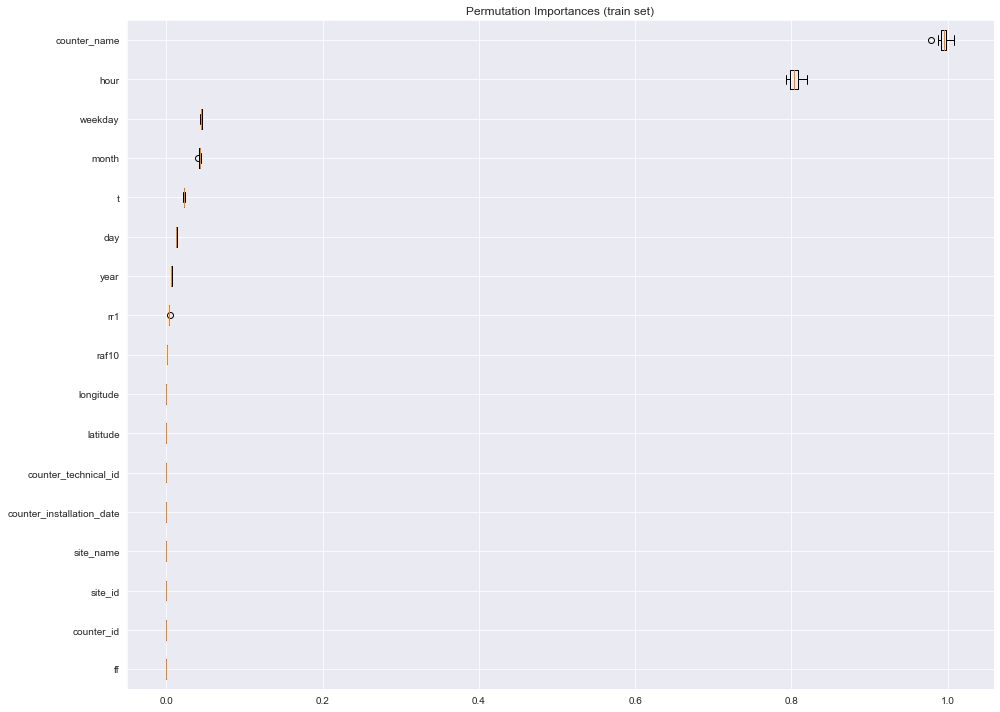

In [20]:
sorted_idx = feature_importances.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(14,10))
ax.boxplot(feature_importances.importances[sorted_idx].T,
           vert=False, labels=X_train_augmented.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

In [21]:
X_train_augmented.columns[sorted_idx]

Index(['ff', 'counter_id', 'site_id', 'site_name', 'counter_installation_date',
       'counter_technical_id', 'latitude', 'longitude', 'raf10', 'rr1', 'year',
       'day', 't', 'month', 'weekday', 'hour', 'counter_name'],
      dtype='object')

In [22]:
# FunctionTransformer(_encode_dates, validate=False)

In [23]:
geoloc = data.drop_duplicates(['site_name'])[['site_name','latitude','longitude']]

geoloc.loc[len(geoloc.index)] = ['center']+list(data.drop_duplicates(['site_name'])[['latitude','longitude']].mean().values)

In [24]:
geoloc['distance_center'] = (geoloc.iloc[:,1:] - geoloc.iloc[-1,1:]).apply(np.linalg.norm,axis=1)

In [25]:
X_train.shape

(455163, 9)

In [26]:
X_train.merge(geoloc.iloc[:-1,[0,-1]],left_on='site_name',right_on='site_name')

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,counter_technical_id,latitude,longitude,distance_center
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.032761
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.032761
2,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.032761
3,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.032761
4,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.032761
...,...,...,...,...,...,...,...,...,...,...
455158,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-08-08 18:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,0.044477
455159,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-08-09 02:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,0.044477
455160,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-08-09 08:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,0.044477
455161,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-08-09 10:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,0.044477


In [30]:
def _distance_center_paris(X):
    X = X.copy()
    geoloc = X.drop_duplicates(['site_name'])[['site_name','latitude','longitude']]
    geoloc.loc[len(geoloc.index)] = ['center']+list(data.drop_duplicates(['site_name'])[['latitude','longitude']].mean().values)
    geoloc['distance_center'] = (geoloc.iloc[:,1:] - geoloc.iloc[-1,1:]).apply(np.linalg.norm,axis=1)
    X = X.merge(geoloc.iloc[:-1,[0,-1]],left_on='site_name',right_on='site_name')
    return X

In [31]:
def _dropping_columns(X):
    X = X.copy()
    X.drop(columns = {'counter_id', 'site_id', 'counter_installation_date',
       'counter_technical_id'},inplace=True)
    return X

In [33]:
computing_center = FunctionTransformer(_distance_center_paris, validate=False)
columns_dropper = FunctionTransformer(_dropping_columns, validate=False)

In [35]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[['date']]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name"]

deleted_cols = ['counter_id', 'site_id', 'counter_installation_date',
       'counter_technical_id']
merging_cols = ['site_name']
numeric_cols = ['t','raf10','ff','rr1','distance_center']

preprocessor = ColumnTransformer([
    ('date', "passthrough", date_cols),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
    ('numeric', 'passthrough', numeric_cols),
])

regressor = HistGradientBoostingRegressor(random_state=0)

pipe =  make_pipeline(
    FunctionTransformer(_merge_external_data, validate=False),
    date_encoder,
    FunctionTransformer(_distance_center_paris, validate=False),
    columns_dropper,
    preprocessor,
    regressor
)

In [36]:
start = time.time()
scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error', error_score=np.nan,verbose=2,n_jobs=-1)
end = time.time()
timed= end - start
print("%1.2e seconds"%timed)
print(f'RMSE: {-scores.mean():.3} ± {(-scores).std():.3}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    6.4s remaining:    6.4s


2.15e+01 seconds
RMSE: nan ± nan


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   21.2s finished


In [37]:
pipe[:4]

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x000001F90369A8B0>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_dates at 0x000001F9009AAA60>)),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function _distance_center_paris at 0x000001F90412F700>)),
                ('functiontransformer-4',
                 FunctionTransformer(func=<function _dropping_columns at 0x000001F90412F4C0>))])

In [38]:
merger = pipe[:4]
X_train_augmented = merger.transform(X_train)
X_test_augmented = merger.transform(X_test)

predictor = pipe[4:]
_ = predictor.fit(X_train_augmented, y_train)
feature_importances = permutation_importance(
    predictor, X_train_augmented[:20000], y_train[:20000], n_repeats=10, random_state=0
)

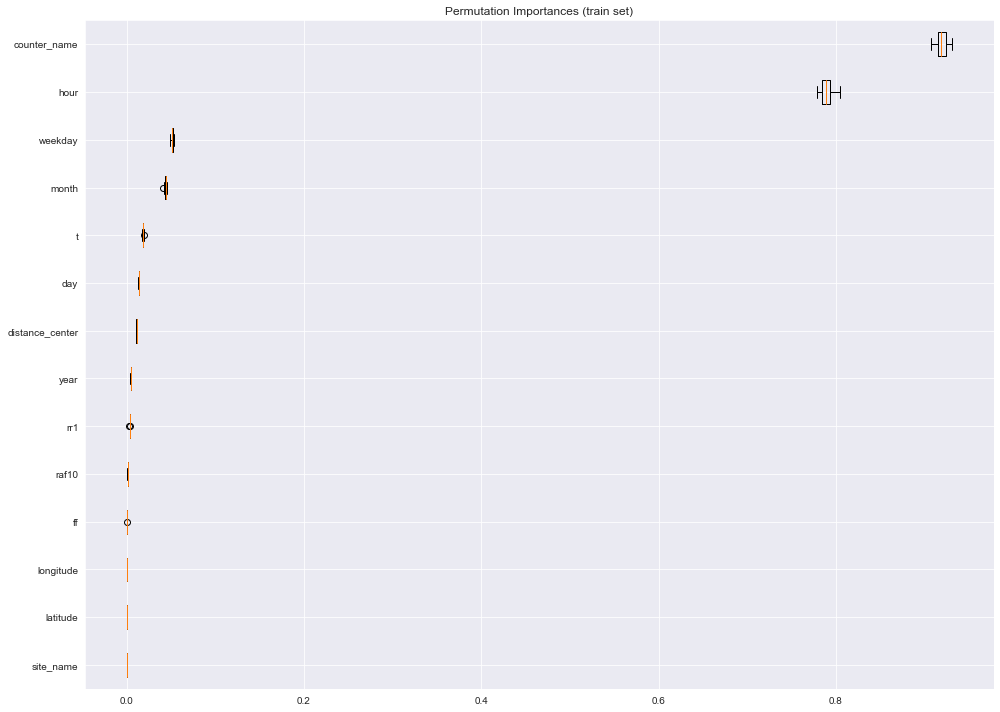

In [39]:
sorted_idx = feature_importances.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(14,10))
ax.boxplot(feature_importances.importances[sorted_idx].T,
           vert=False, labels=X_train_augmented.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

In [123]:
__file__ = Path('submissions') /  'starting_kit' /  'estimator.py'
file_path = Path(__file__).parent / 'jardins.csv'

In [124]:
file_path

WindowsPath('submissions/starting_kit/jardins.csv')

In [128]:
df_parcs = pd.read_csv(file_path,sep=";")

In [129]:
df_parcs['commune'].value_counts()

BOULOGNE-BILLANCOURT    44
ISSY-LES-MOULINEAUX     35
MEUDON                  32
SEVRES                  22
CHAVILLE                22
VANVES                  18
MARNES-LA-COQUETTE       9
VILLE D'AVRAY            7
Name: commune, dtype: int64

In [45]:
print(X_train.date.dt.date.min())
X_train.date.dt.date.max()

2020-09-01


datetime.date(2021, 8, 9)

In [67]:
def _schools_holidays(X):
    X = X.copy()
    toussaint = pd.date_range('17/10/2021','2/11/2021')
    xmas = pd.date_range('11/19/2020','4/1/2021')
    winter = pd.date_range('2/13/2021','1/3/2021')
    paques = pd.date_range('4/10/2021','4/26/2021')
    summer = pd.date_range('6/7/2021','9/4/2021')
    holidays = [toussaint,xmas,winter,paques]
    total_dates = pd.date_range(X.date.dt.date.min(),X.date.dt.date.max())
    scores = np.zeros(len(total_dates))
    final_serie = pd.Series(data=scores, index = total_dates)
    for holiday in holidays:
        final_serie += final_serie.apply(lambda date : 1 if date in holiday else 0).values
    return final_serie

In [69]:
_schools_holidays(X_train).sum()

0.0

In [59]:
[element for element in pd.date_range('2/13/2021','3/1/2021') if element in pd.date_range(X_train.date.dt.date.min(),X_train.date.dt.date.max())]

[Timestamp('2021-02-13 00:00:00', freq='D'),
 Timestamp('2021-02-14 00:00:00', freq='D'),
 Timestamp('2021-02-15 00:00:00', freq='D'),
 Timestamp('2021-02-16 00:00:00', freq='D'),
 Timestamp('2021-02-17 00:00:00', freq='D'),
 Timestamp('2021-02-18 00:00:00', freq='D'),
 Timestamp('2021-02-19 00:00:00', freq='D'),
 Timestamp('2021-02-20 00:00:00', freq='D'),
 Timestamp('2021-02-21 00:00:00', freq='D'),
 Timestamp('2021-02-22 00:00:00', freq='D'),
 Timestamp('2021-02-23 00:00:00', freq='D'),
 Timestamp('2021-02-24 00:00:00', freq='D'),
 Timestamp('2021-02-25 00:00:00', freq='D'),
 Timestamp('2021-02-26 00:00:00', freq='D'),
 Timestamp('2021-02-27 00:00:00', freq='D'),
 Timestamp('2021-02-28 00:00:00', freq='D'),
 Timestamp('2021-03-01 00:00:00', freq='D')]

In [58]:
pd.date_range('2/13/2021','3/1/2021')

DatetimeIndex(['2021-02-13', '2021-02-14', '2021-02-15', '2021-02-16',
               '2021-02-17', '2021-02-18', '2021-02-19', '2021-02-20',
               '2021-02-21', '2021-02-22', '2021-02-23', '2021-02-24',
               '2021-02-25', '2021-02-26', '2021-02-27', '2021-02-28',
               '2021-03-01'],
              dtype='datetime64[ns]', freq='D')